In this project I used or implemented the Variational Quantum Eigensolver (VQE) algorithm on several quantum design platforms and tested it on a reduction of an NP-Complete problem (the partitioning problem) to Ising Hamiltonian eigenvalue search. In this document I will present the mathematical background of the project, a comparison of the results from the different platforms and future work suggestions. 

# Mathematical Background

## VQE - The Variational Quantum Eigensolver algorithm

VQE is a hybrid quantum-classical algorithm using the quantum computer only for a classically intractable subroutine and has been shown to be robust against noise, and capable of finding the minimal eigenvalue of an ising model.
Formally stated, given a Hermitian matrix H with an unknown minimum eigenvalue
λmin associated with the eigenstate  |ψmin⟩, VQE provides an estimate  λθ bounding  λmin:

λmin
≤
λ
θ
≡
⟨
ψ
(
θ
)
|
H
|
ψ
(
θ
)
⟩
 
where  |ψ(θ)⟩
  is the eigenstate associated with λθ
 . By applying a parameterized circuit, represented by  
U(θ), to some arbitrary starting state  |ψ⟩, the algorithm obtains an estimate  
U
(
θ
)
|
ψ
⟩
≡
|
ψ
(
θ
)
⟩
  on  |ψmin⟩.
   
   The estimate is iteratively optimized by a classical controller changing the parameter  θ minimizing the expectation value of  
⟨
ψ
(
θ
)
|
H
|
ψ
(
θ
)
⟩
 .

To complete the specification of VQE, one needs to specify the form of the parameterized wavefunction  |
ψ
(
θ
)
⟩ , known as the ansatz, as an initial guess approximating |ψmin⟩. Also, the success of the VQE algorithm greatly depends on the classical optimization method, since the algorithm can get stuck in local minima and return not optimal (not minimal) eigenvalue.

One of the advantages of the VQE algorithm is its ability to use the pauli strings constructing an Ising model to efficiently compute the minimal eigenvalue of the model, classicaly intractable due to its exponential size. In this project, I used the VQE algorithm to efficiently compute the minimal eigenvalue of an Ising model representing certain partitioning problem.

## Anzats - The Parametrized Wavefunction

To use the VQE algorithm on a quantum computer, a sistematic approach to varying the ansatz (the initial guess approximating |ψmin⟩) is required. VQE does that using a parameterized circuit with a fixed form. Such a circuit is often called a variational form, and its action may be represented by the linear transformation U(θ). A variational form is applied to a starting state   |ψ⟩ (such as the vacuum state |0⟩, or the Hartree Fock state) and generates an output state  U(θ)|ψ⟩≡|ψ(θ)⟩. 

Iterative optimization over  |ψ(θ)⟩ aims to yield an expectation value  
⟨ψ(θ)|H|ψθ)⟩≈Egs≡λmin. 

Ideally, |ψ(θ)⟩ will be close to |ψmin⟩ (where 'closeness' is characterized by either state fidelity, or Manhattan distance) although in practice, useful bounds on  Egs can be obtained even if this is not the case.

Moreover, a fixed variational form with a polynomial number of parameters can only generate transformations to a polynomially sized subspace of all the states in an exponentially sized Hilbert space. Consequently, various variational forms exist. Some variational forms, such as UCCSD, utilize domain specific knowledge to generate close approximations based on the problem's structure. For example, when calculating the ground state energy of a molecule, the number of particles in the system is known a priori. Therefore, if a starting state with the correct number of particles is used, by limiting the variational form to only producing particle preserving transformations, the number of parameters required to span the new transformation subspace can be greatly reduced. 

Other variational forms, such as Ry and RyRz, are heuristically designed, without consideration of the target domain. In this approach, gates are layered such that good approximations on a wide range of states may be obtained. 

Three essential configurations of the anzatses are: the number of qubits in the system, the depth setting, and the entanglement setting. 

A single layer of a variational form specifies a certain pattern of single qubit rotations and CX gates. The depth setting says how many times the variational form should repeat this pattern. By increasing the depth setting, at the cost of increasing the number of parameters that must be optimized, the set of states the variational form can generate increases. Finally, the entanglement setting selects the configuration, and implicitly the number, of CX gates. For example, when the entanglement setting is linear, CX gates are applied to adjacent qubit pairs in order, and thus n−1 CX gates are added per layer. 

In this project, since I don't have prior knowledge about the problem solved by the VQE, I used the EfficientSU2 anzats which is constructed with the RyRz gates, depth of 3 and linear entanglment. It worked well in the Qiskit platform, but gave inaccurate results in the Classiq platform and therefore in Classiq I used an anzats constructed of XRy gates, which returned better results. All the results can be seen in the "Classiq_Solving_The_Partitioning_Problem" document in the GIT. 



This is the anzats I used in the Qiskit testing:

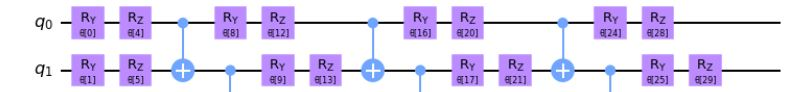

This is the RyRz anzats I tested in the classiq implementation:

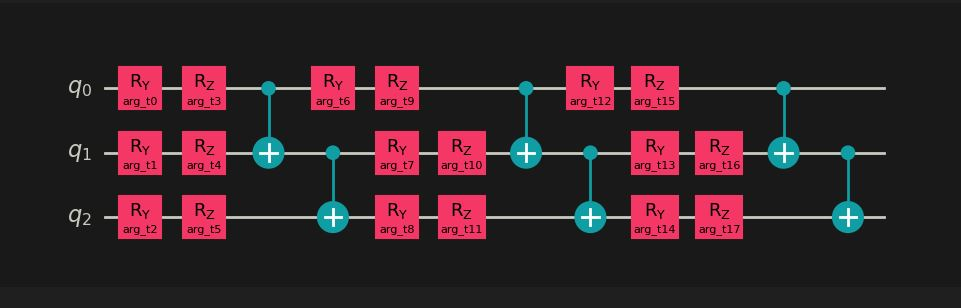)

And this is the X anzats I tested in the Classiq implementation:

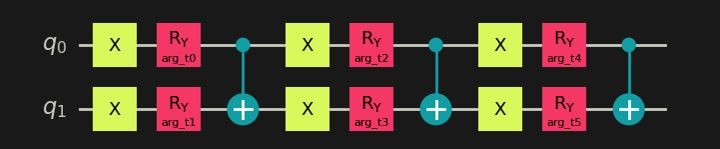

## Optimizer 

Once an efficient anzats has been selected, its parameters must be optimized to minimize the expectation value of the target Hamiltonian. The parameter optimization process has various challenges. For example, quantum hardware has various types of noise and so objective function evaluation (energy calculation) may not necessarily reflect the true objective function. Additionally, some optimizers perform a number of objective function evaluations dependent on cardinality of the parameter set. An appropriate optimizer should be selected by considering the requirements of an application.

An appropriate optimizer for optimizing a noisy objective function is the Simultaneous Perturbation Stochastic Approximation optimizer (SPSA). SPSA approximates the gradient of the objective function with only two measurements. It does so by concurrently perturbing all of the parameters in a random fashion, in contrast to gradient descent where each parameter is perturbed independently. When utilizing VQE in either a noisy simulator or on real hardware, SPSA is recommended as the classical optimizer.

When noise is not present in the cost function evaluation (such as when using VQE with a statevector simulator), a wide variety of classical optimizers may be useful. Two such optimizers are the Sequential Least Squares Programming optimizer (SLSQP) and the Constrained Optimization by Linear Approximation optimizer (COBYLA). It is worth noting that COBYLA only performs one objective function evaluation per optimization iteration (and thus the number of evaluations is independent of the parameter set's cardinality). Therefore, if the objective function is noise-free and minimizing the number of performed evaluations is desirable, it is recommended to try COBYLA.

In this project, since the VQE was tested mostly on a statevector simulator (both simulator and noiseless environment) due to certain problems with the qasm simulator, I chose to use the COBYLA and the L_BFGS_B optimizers, which are described below.

It's worth noting that in the Qiskit platform, the COBYLA optimizer worked better with the qasm simulator, while the L_BFGS_B optimizer worked better with the aer_statevector simulator. All the results can be seen in the "Qiskit_Solving_The_Partitioning_Problem" document in the GIT. 

### COBYLA - Constrained Optimization by Linear Approximation Optimizer

COBYLA is a numerical optimization method for constrained problems where the derivative of the objective function is not known. It works by iteratively approximating the actual constrained optimization problem with linear programming problems. During an iteration, an approximating linear programming problem is solved to obtain a candidate for the optimal solution. The candidate solution is evaluated using the original objective and constraint functions, yielding a new data point in the optimization space. This information is used to improve the approximating linear programming problem used for the next iteration of the algorithm. When the solution cannot be improved anymore, the step size is reduced, refining the search. When the step size becomes sufficiently small, the algorithm finishes.

### L_BFGS_B - Limited-memory Broyden-Fletcher-Goldfarb-Shanno Bound Optimizer

L_BFGS_B is a Limited-memory BFGS Bound optimizer.

The target goal of Limited-memory Broyden-Fletcher-Goldfarb-Shanno Bound (L-BFGS-B) is to minimize the value of a differentiable scalar function . This optimizer is a quasi-Newton method, meaning that, in contrast to Newtons’s method, it does not require ’s Hessian (the matrix of ’s second derivatives) when attempting to compute ’s minimum value.

Like BFGS, L-BFGS is an iterative method for solving unconstrained, non-linear optimization problems, but approximates BFGS using a limited amount of computer memory. L-BFGS starts with an initial estimate of the optimal value, and proceeds iteratively to refine that estimate with a sequence of better estimates.

The derivatives of  are used to identify the direction of steepest descent, and also to form an estimate of the Hessian matrix (second derivative) of . L-BFGS-B extends L-BFGS to handle simple, per-variable bound constraints.

# From Partitioning Problem To Finding The Minimal Eigenvalue Problem

In this project, I use the paper ''Ising Formulations of Many NP Problems'' to formulate a NP-complete problem (The partitioning problem) as an Ising model,  and using the VQE find its minimal eigenvalue which represents the minimal difference between the two groups in the optimal partiotioning of the set.

## The Partitioning Problem

Number partitioning asks the following: given a set of N positive numbers   

                            S = {n1, . . . , nN }

is there a partition of this set of numbers into two disjoint subsets R and S − R, such that the sum of the elements in both sets is the same? 

For example, can one divide a set of assets with values 

                              S = {1, 3 , 2, 4} 

fairly between two people? yes! R = {1,4}, S - R = {3,2}.

 This problem is known to be NP-complete

## Ising Model

As it is described in section 1.1 in the paper ''Ising Formulations of Many NP Problems'', a classical Ising model can be written as a quadratic function of a set of N spins, when $s_{i} = ±1$:

  $H(s_{1},s_{2},\ldots,s_{N})=-\sum_{i<j}J_{ij}s_{i}s_{j}-\sum_{i=1}^{N}h_{i}s_{i}$

The quantum version of this Hamiltonian is simply:

$H_{p}=H(\sigma_{1}^{z},\sigma_{2}^{z},\ldots,\sigma_{N}^{z})$

When $\sigma_{i}^{z}$ are Z pauli matrices.

## Ising Model formulation of the partitioning problem

According to the explanation in section 2.1 in the paper ''Ising Formulations of Many NP Problems'', the partitioning problem can be phrased as Ising model as follows:

$H=A\left(\sum_{i=1}^{N}n_{i}s_{i}\right)^{2}$

When H is an energy function, $s_{i} = ±1$ is an Ising spin variable, N is the size of the numbers set and A > 0 is some positive constant (for simplicity I will scale this parameter later to 1).

If there is a solution to the Ising model with H = 0, then there is a configuration of spins where the sum of the $n_{i}$ for the +1 spins is the same as the sum of the $n_{i}$ for the −1 spins. Thus, if the ground state energy is H = 0, there is a solution to the number partitioning problem.

## Example:

So for the set S = {1, 1} , the Ising model equals to:

$H=A\left(\sum_{i=1}^{N}n_{i}s_{i}\right)^{2}=$
$\left(1\cdot s_{1}+1\cdot s_{2}\right)^{2}=1\cdot s_{1}^{2}+1\cdot s_{1}s_{2}+1\cdot s_{2}s_{1}+1\cdot s_{2}^{2}=$$
1\cdot\sigma_{z}^{1}\sigma_{z}^{1}+1\cdot\sigma_{z}^{1}\sigma_{z}^{2}+1\cdot\sigma_{z}^{2}\sigma_{z}^{1}+1\cdot\sigma_{z}^{2}\sigma_{z}^{2}=$$
\left(\begin{array}{cccc}
1 & 0 & 0 & 0\\
0 & 1 & 0 & 0\\
0 & 0 & 1 & 0\\
0 & 0 & 0 & 1
\end{array}\right)+\left(\begin{array}{cccc}
1 & 0 & 0 & 0\\
0 & -1 & 0 & 0\\
0 & 0 & -1 & 0\\
0 & 0 & 0 & 1
\end{array}\right)+\left(\begin{array}{cccc}
1 & 0 & 0 & 0\\
0 & -1 & 0 & 0\\
0 & 0 & -1 & 0\\
0 & 0 & 0 & 1
\end{array}\right)+\left(\begin{array}{cccc}
1 & 0 & 0 & 0\\
0 & 1 & 0 & 0\\
0 & 0 & 1 & 0\\
0 & 0 & 0 & 1
\end{array}\right)=\left(\begin{array}{cccc}
4 & 0 & 0 & 0\\
0 & 0 & 0 & 0\\
0 & 0 & 0 & 0\\
0 & 0 & 0 & 4
\end{array}\right)$

We can see that the Hamiltonian has 2 eigenvalues that equals to 0, which means, as we expected, that there are 2 possible partitions which satisfy the problem (It doesn't matter in which group each number is, so there are 2 possible ways to devide the set).

# Project 

In this project I used the VQE algorithm on several quantum design platforms and tested it on a reduction of an NP-Complete problem (the partitioning problem) to Ising Hamiltonian eigenvalue search. In all the platforms, I initially tested my solution on small 2-qubit problems, both solvable and unsolvable, and then generalized my code to N-qubit solution and tested it on relatively large problem sets.
All the exact results of the work can be found in the "Qiskit_Solving_The_Partitioning_Problem", "Qiskit_large_Problems","Classiq_Solving_The_Partitioning_Problem" documents in the GIT. 

## Results

I ran my code on 72 partitioning problems, 36 solvable and 36 unsolvable (4 problems for each number of qubits, to test a variety of problems). For each problem I measured the deviation of the computed minimal eigenvalue by the VQE from the desired result (the real minimal eigenvalue).
In the graphs below, I show the average deviation from the desired result for each number of qubits in the partitioning problem.

### Qiskit

All the problems were tested using the aer_statevector simulator and l_bfgs_b optimizer.

#### Solvable Problems

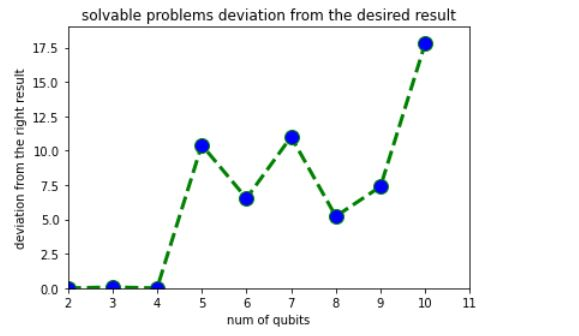

#### Unsolvable Problems

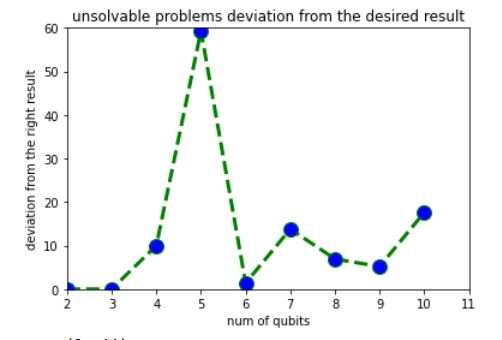

### Classiq

All the problems were tested using the aer_statevector simulator and cobyla optimizer.

#### Solvable Problems

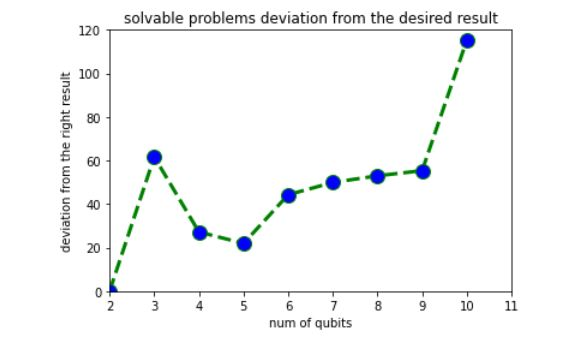

#### Unsolvable Problems

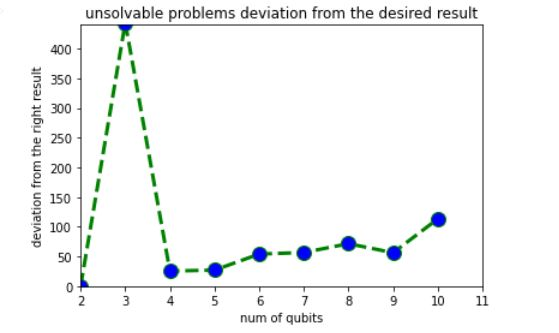

### Discussion

We can see that for a small amount of qubits the VQE algorithm gives accurate results, but as the problems get bigger and contain more qubits the VQE looses its accuracy and deviate more and more from the right results.

There can be several possible explenations to this inaccuracy. This can be explained by a bug in my code, of course. Since I'm using a statevector simulator and not qasm or real quantum hardware, I highly doubt that a noise is to blame. The most likely reason to the graph's behavior, in my opinion, is that it's stuck in local minima. This theory is strengthened by the "outlier" in the second graphs 5 qubit point.



Looking closely on the two first problems in the 5 qubits unsolvable problems (Qiskit):

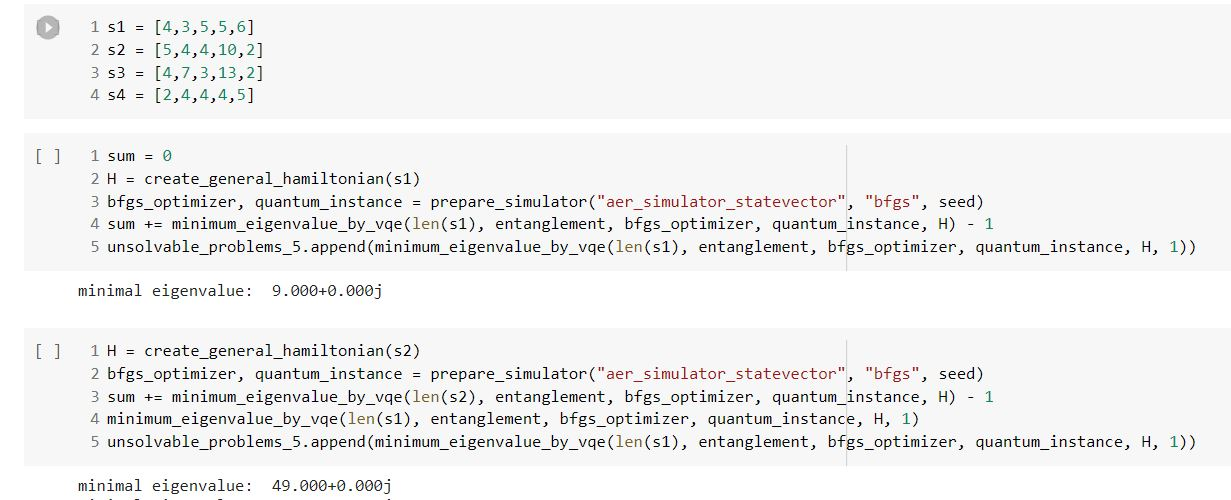

I noticed that in the first problem the VQE returned 9, which is the squared value of 3, the second big eigenvalue of the problem's Hamiltonian.
The same behavior repeats in the second problem; The VQE returns 49, which is the squared value of 7, the second big eigenvalue of the problem's Hamiltonian - its optimizer was stuck on local minimas.

Some practical knowledge I gained during the work on the different platforms also worths mentioning:



*   Qiskit and Classiq have a built in VQE module, which makes the work with them much easier then with Amazon Braket.

*   Qiskit has very convinient documentations and tutorials, while Classiq and Amazon Braket have much smaller and not intuitive documentations, which make Qiskit much more user-friendly.

* Classiq's installation process was very unclear and therefore long.

* Classiq returns error when I tried to use it with the qasm simulator. Also Qiskit returned inaccurate results when I tried to use the qasm simulator with the l_bgfs_b optimizer.

* In Qiskit platform, the COBYLA optimizer worked better (more accurate) with the qasm simulator, while the L_BFGS_B optimizer worked better with the aer_statevector simulator.








# Open Questions

This project was a great experience, but still many questions stay open for future investigation:



*   In the current implementation, my code can't be used for solving real life large NP-Complete problems (such as the MAPF problem), because of the inaccuracy of the results. If my assumption is right, and the problem is that the optimizer gets stuck on local minimas, can an optimizer (and its parameters) be chosen automatically to avoid the issue? Can Machine Learning be used to adjust the optimizer's parameters?


*   The VQE algorithm returns the square of the minimal eigenvalue of the hamiltonian representing the problem, which, as I stated before, represents the difference between the sum of the subsets of the optimal partitioning of the partitioning problem. But can the partitioning itself (which number in the original set belongs to which subset) be concluded from the VQE algorithm results? 

* The original purpose of this project was to solve - with a chain of reductions - the MAPF problem, a NP-complete problem, using the VQE algorithm. But the reductions themselves add parameters to the problem, and the complexity of the VQE algorithm depends on the optimizer chosen. Is the VQE solution of the MAPF problem really better (complexity vise) than the classical approximation solutions?



# References

1.	Peruzzo, A., McClean, J., Shadbolt, P., Yung, M.H., Zhou, X.Q., Love, P.J., Aspuru-Guzik, A. and O’brien, J.L., 2014. A variational eigenvalue solver on a photonic quantum processor. Nature communications, 5(1), pp.1-7.
2.	Lucas, Andrew. “Ising Formulations of Many NP Problems.” Frontiers in Physics 2 (2014). https://doi.org/10.3389/fphy.2014.00005.
3.	https://en.wikipedia.org/wiki/Ising_model
4.	https://en.wikipedia.org/wiki/Partition_problem
5.	https://qiskit.org/textbook/ch-applications/vqe-molecules.html
